In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
sys.path.append('../')
from plancklens import utils
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
from dance.filtering import WienerFilter
from dance.qe import Reconstruct
from dance.delens import Delens
from dance.utils import bin_cmb_spectrum

MPI startup(): FI_PSM3_UUID was not generated, please set it to avoid possible resources ownership conflicts between MPI processes


In [3]:
basedir = '/mnt/sdceph/users/alonappan/DANCE'

In [4]:
recon_aniso = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p")

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
/mnt/home/alonappan/anaconda3/cstm_pkgs/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


In [5]:
delens = Delens(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="p_p",lmin_delens=50,lmax_delens=4096)
recon_delens = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p",delens=delens)

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


Delens Filtering


In [6]:
ap_bd = []
for i in tqdm(range(10)):
    oalm = recon_aniso.get_qlm(i)
    talm = recon_aniso.get_qlm_th(i)
    cl = hp.alm2cl(oalm,talm)
    ap_bd.append(cl)
ap_bd = np.array(ap_bd)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


In [7]:
ap_ad = []
for i in tqdm(range(10)):
    oalm = recon_delens.get_qlm(i)
    talm = recon_delens.get_qlm_th(i)
    cl = hp.alm2cl(oalm,talm)
    ap_ad.append(cl)
ap_ad = np.array(ap_ad)

100%|██████████| 10/10 [00:49<00:00,  4.92s/it]


In [8]:
ap_bd_bin = []
for i in tqdm(range(10)):
    bd_bin, bcl = bin_cmb_spectrum(ap_bd[i],2)
    ap_bd_bin.append(bcl)
ap_bd_bin = np.array(ap_bd_bin)

100%|██████████| 10/10 [00:00<00:00, 47.31it/s]


In [10]:
ap_ad_bin = []
for i in tqdm(range(10)):
    ad_bin, bcl = bin_cmb_spectrum(ap_ad[i],2)
    ap_ad_bin.append(bcl)
ap_ad_bin = np.array(ap_ad_bin)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 45.74it/s]


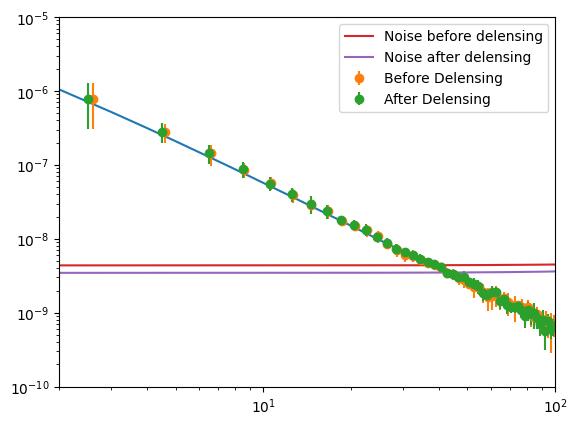

In [11]:
plt.loglog(recon_aniso.cmb.cl_aa())
plt.errorbar(bd_bin+0.1,ap_bd_bin.mean(axis=0),ap_bd_bin.std(axis=0),fmt='o', label='Before Delensing')
plt.errorbar(ad_bin,ap_ad_bin.mean(axis=0),ap_ad_bin.std(axis=0),fmt='o', label='After Delensing')
plt.loglog(recon_aniso.get_n0(0),label='Noise before delensing')
plt.loglog(recon_delens.get_n0(0),label='Noise after delensing')
plt.ylim(1e-10,1e-5)
plt.xlim(2,100)
plt.legend()

In [12]:
import emcee

In [52]:
data = ap_bd_bin.copy()
bb = bd_bin.copy()


In [53]:
sel = np.where((bb>2) & (bb<100))[0]

In [54]:
data = data[:,sel]
bb = bb[sel]

In [55]:
def theory(acb,L):
      return np.exp(acb) * 2 * np.pi / ( L**2 + L + 1e-30)

def chi_sq(acb):
        theory_cl = theory(acb,bb)
        delta = data.mean(axis=0) - theory_cl
        return np.sum((delta)**2 / data.std(axis=0)**2)

def log_likelihood(theta):
    return -0.5 * chi_sq(theta)


def log_prior(theta):
    if -14 < theta < -12:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


def get_pos_nwalkers_ndim():
    pos = [-13.8] + 1e-1 * np.random.randn(32, 1)
    nwalkers, ndim = pos.shape
    return pos, nwalkers, ndim

def get_samp():
    pos, nwalkers, ndim = get_pos_nwalkers_ndim()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=24,)
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.get_chain(discard=100, thin=15, flat=True)
    return samples


In [56]:
samp = get_samp()

  0%|          | 0/5000 [00:00<?, ?it/s]

/mnt/home/alonappan/anaconda3/envs/cosmo/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:10<00:00, 479.27it/s]


In [57]:
sampl = np.exp(samp)

In [51]:
sampl.mean(), sampl.std()

(1.049856520611219e-06, 2.7003668341863068e-08)

In [58]:
sampl.mean(), sampl.std()

(1.042926205015364e-06, 2.8748856470786095e-08)

In [59]:
1 - 2.7/2.9

0.06896551724137923